In [13]:
%load_ext autoreload
%autoreload 2
%aimport

%matplotlib inline 

import torch
import matplotlib.pyplot as plt
from einops import rearrange
from typing import Union
from torch import Tensor, nn

from bliss.catalog import TileCatalog, get_images_in_tiles
from bliss.reporting import DetectionMetrics
from case_studies.psf_homogenization.psf_decoder import PsfSampler, GalsimBlenswithPSF
from bliss.models.detection_encoder import (
    LogBackgroundTransform,
    ConcatBackgroundTransform,
    EncoderCNN,
    make_enc_final,
)

# check GPU is configured correctly
device = torch.device('cuda:0')
!echo $CUDA_VISIBLE_DEVICES

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:

5


In [14]:
# load models
from hydra import compose, initialize
from hydra.utils import instantiate
from bliss.encoder import Encoder

with initialize(config_path="../config"):
    cfg = compose("config", overrides=[])

In [15]:
prior = instantiate(cfg.datasets.galsim_blended_galaxies_psf.prior) 
decoder = instantiate(cfg.datasets.galsim_blended_galaxies_psf.decoder)
background = instantiate(cfg.datasets.galsim_blended_galaxies.background)
tile_slen = 4
max_tile_n_sources = 1
num_workers = 5
batch_size = 10000
n_batches = 1
psf_sampler = PsfSampler(0.5, 1.2)

ds_psf = GalsimBlenswithPSF(prior, decoder, background, tile_slen, max_tile_n_sources, num_workers=0, batch_size=5, n_batches=1, psf_sampler=psf_sampler, std_psf_fwhm=1.0, valid_n_batches=1)



torch.Size([5, 1, 88, 88])
torch.Size([5, 1, 88, 88])



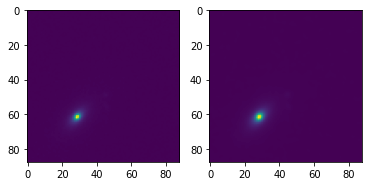

In [17]:
for x in ds_psf.train_dataloader():
    print(x["images"].shape)
    print(x["noisy_image"].shape)
    print()
    plt.figure()
    plt.subplot(121)
    plt.imshow(x['noisy_image'][0, 0].numpy())
    plt.subplot(122)
    plt.imshow(x["images"][0, 0].numpy())
    plt.show()
plt.close()

In [33]:
for x in ds_psf.test_dataloader():
    print(x["n_sources"])
ds_psf.tile_slen

tensor([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

        [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
         [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
         [0,

4

In [18]:
model_checkpoint = torch.load("/home/wangchv/bliss/case_studies/psf_homogenization/output/sdss_detection_encoder_full_decoder_homo/version_0/checkpoints/epoch=989-val_loss=-0.014.ckpt")



In [19]:
model_checkpoint.keys()


dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])

In [35]:
n_bands = 1
tile_slen = 4
ptile_slen = 52
max_detection = 1
channel = 8
spatial_dropout = 0.0
hidden = 128
dropout = 0.0

def dist_param_groups():
        return {
            "loc_mean": {"dim": 2},
            "loc_logvar": {"dim": 2},
            "log_flux_mean": {"dim": n_bands},
            "log_flux_logvar": {"dim": n_bands},
        }

n_params_per_source = sum(param["dim"] for param in dist_param_groups.values())
n_total_detections = max_detection * (max_detection + 1) // 2
n_source_params = n_total_detections * n_params_per_source
count_simplex_dim = 1 + max_detection
dim_out_all = n_source_params + count_simplex_dim
dim_enc_conv_out = ((ptile_slen + 1) // 2 + 1) // 2

input_transform = ConcatBackgroundTransform()
n_bands_in = input_transform.output_channels(n_bands)
enc_conv = EncoderCNN(n_bands_in, channel, spatial_dropout)

enc_final = make_enc_final(
    channel * 4 * dim_enc_conv_out ** 2,
    hidden,
    dim_out_all,
    dropout,
)
log_softmax = nn.LogSoftmax(dim=1)

In [ ]:
def encoder(image_ptiles: Tensor) -> Dict[str, Tensor]:
    transformed_ptiles = input_transform(image_ptiles)
    enc_conv_output = enc_conv(transformed_ptiles)
    enc_final_output = enc_final(enc_conv_output)

    dim_out_all = enc_final_output.shape[1]
    dim_per_source_params = dim_out_all - (max_detection + 1)
    per_source_params, n_source_free_probs = torch.split(
        enc_final_output, (dim_per_source_params, max_detection + 1), dim=1
    )
    per_source_params = rearrange(
        per_source_params,
        "n_ptiles (td pps) -> n_ptiles td pps",
        td=n_total_detections,
        pps=n_params_per_source,
    )

    n_source_log_probs = log_softmax(n_source_free_probs)

    return {
        "per_source_params": per_source_params,
        "n_source_log_probs": n_source_log_probs,
    }

In [ ]:
def validation(model, batch):
        """Pytorch lightning method."""
        batch_size = len(batch["images"])
        
        catalog_dict = {
            "locs": batch["locs"][:, :, :, 0 : model.max_detections],
            "log_fluxes": batch["log_fluxes"][:, :, :, 0 : model.max_detections],
            "galaxy_bools": batch["galaxy_bools"][:, :, :, 0 : model.max_detections],
            "n_sources": batch["n_sources"].clamp(max=model.max_detections),
        }
        true_tile_catalog = TileCatalog(model.tile_slen, catalog_dict)
        true_full_catalog = true_tile_catalog.to_full_params()
        image_ptiles = get_images_in_tiles(
            torch.cat((batch["images"], batch["background"]), dim=1),
            model.tile_slen,
            model.ptile_slen,
        )
        image_ptiles = rearrange(image_ptiles, "n nth ntw b h w -> (n nth ntw) b h w")
        dist_params = model.encode(image_ptiles)
        est_catalog_dict = model.variational_mode(dist_params)
        est_tile_catalog = TileCatalog.from_flat_dict(
            true_tile_catalog.tile_slen,
            true_tile_catalog.n_tiles_h,
            true_tile_catalog.n_tiles_w,
            est_catalog_dict,
        )
        est_full_catalog = est_tile_catalog.to_full_params()

        metrics = DetectionMetrics(true_full_catalog, est_full_catalog)
        model.log("val/precision", metrics["precision"], batch_size=batch_size)
        model.log("val/recall", metrics["recall"], batch_size=batch_size)
        model.log("val/f1", metrics["f1"], batch_size=batch_size)
        model.log("val/avg_distance", metrics["avg_distance"], batch_size=batch_size)
        return batch
